The Answer for question 1:

Positional information degradation in deep Transformer architectures is a well-documented issue in the literature. When absolute positional encodings—such as the sinusoidal embeddings introduced by Vaswani et al. (2017)—are added only at the input layer, their signal can diminish across layers as the network deepens. Each self-attention layer mixes token representations, and without reinforcement mechanisms, later layers tend to focus more on semantic or contextual content, effectively treating the sequence as a bag of words if the positional cues fade or become entangled . Although residual connections are intended to propagate input information forward, empirical studies (Dufter et al., 2022) show that position information is often attenuated or overridden by attention patterns that prioritize token meaning over position .

This degradation becomes critical for order-sensitive tasks, such as parsing, logical reasoning, or document-level modeling. To address this, researchers have proposed mechanisms such as layer-wise re-injection of position signals, as seen in TUPE (Ke et al., 2020), or disentangled attention in DeBERTa (He et al., 2021), where position and content are encoded and processed separately in attention computations . These designs help maintain structural awareness throughout deep architectures and improve generalization to long or shifted sequences. Without such mechanisms, Transformers may suffer from limited positional inductive bias, causing unstable performance when sequence length or structure distribution changes at inference time .


References:
Wang, S. et al. (2020). Linformer: Self-Attention with Linear Complexity. arXiv:2006.04768

Dai, Z. et al. (2019). Transformer-XL: Attentive Language Models Beyond a Fixed-Length Context. ACL 2019

Ke, G. et al. (2020). Rethinking Positional Encoding in Language Pretraining. ICLR 2021

Vaswani, A. et al. (2017). Attention is All You Need. NeurIPS 2017

He, P. et al. (2021). DeBERTa: Decoding-enhanced BERT with Disentangled Attention. ICLR 2021

Shaw, P. et al. (2018). Self-Attention with Relative Position Representations. NAACL 2018

Dufter, P. et al. (2022). Position Information in Transformers: An Overview. Computational Linguistics. https://doi.org/10.1162/coli_a_00445

The Answer for question 2:

In this section, we import the necessary Python libraries for building, training, and evaluating a simple attention-based model with different types of positional encodings.

In [108]:
import torch
# Used throughout for tensor creation, mathematical operations, and moving data to GPU.

import torch.nn as nn
# Used to define neural network components such as:
# - nn.Embedding (for token embeddings),
# - nn.Linear (for projections),
# - nn.Module (for custom model classes).

import torch.nn.functional as F
# Used inside the model for operations like:
# - F.softmax (in attention),
# - F.cross_entropy (as the loss function).

import time
# Used to measure training duration of each model variant:
#   start = time.time(); ... ; elapsed = time.time() - start

import random
# Sets Python's random seed for reproducibility of experiments.

import numpy as np
# Used for math functions inside positional encoding (e.g., np.exp, np.sqrt).
# Also used in scaling the dot product attention score: / np.sqrt(d_model)

from torch.utils.data import DataLoader, TensorDataset
# TensorDataset: Wraps inputs and targets into a dataset object.
# DataLoader: Used to iterate over dataset in mini-batches during training.

import pandas as pd
# Used to store and print the comparison results between positional encodings
# as a nice table: PE type, average loss, training time.


## Synthetic Data Generation for Positional Encoding and Attention Depth Evaluation

We construct a synthetic dataset designed to evaluate the necessity of positional encodings and deep multi-layer attention. Each input sequence has a fixed length of 64 tokens and follows the structure:

Here, `a` is a randomly sampled base token from `[10, vocab_size - 20]`. The tokens follow an arithmetic progression with fixed structural markers (`START`, `MIDDLE`, `END`) inserted at known positions. The rest of the sequence is padded with `0` to maintain fixed length.

### Why Positional Encoding is Necessary

The same token value (e.g., `a+1`) plays different roles depending on its position. Without position encodings, the model cannot distinguish whether a token precedes or follows `MIDDLE`. Thus, models must rely on position-aware embeddings (e.g., sinusoidal or learnable) to correctly infer token relationships.

### Why Multiple Attention Layers are Required

Predicting the `END` token requires integrating information across multiple, non-adjacent positions (`START`, `a+4`, `MIDDLE`). A single-layer transformer lacks the receptive field to perform this long-range composition. Deeper models (e.g., 4–16 layers) are necessary to propagate and merge relevant context.

This construction provides a controlled testbed for comparing position encoding methods under varying depth and training regimes.


In [109]:
# Set seed for reproducibility
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

# Parameters
seq_len = 64
batch_size = 32
vocab_size = 100
d_model = 64
num_samples = 1000

# === Step 1: Create structured sequences ===
def generate_structured_sequence(vocab_size, seq_len):
    """
    Generate sequences with a repeated pattern like:
    [ START, a, a+1, a+2, MIDDLE, a+3, a+4, END ] + padding
    This enforces positional dependence.
    """
    base = random.randint(10, vocab_size - 20)
    pattern = [base, base+1, base+2, base+3, base+4]
    
    START, MIDDLE, END = 1, 2, 3
    seq = [START] + pattern[:3] + [MIDDLE] + pattern[3:] + [END]
    
    # Fill the rest with padding (e.g., PAD = 0)
    while len(seq) < seq_len:
        seq.append(0)
    
    return seq[:seq_len]

# === Step 2: Generate full dataset ===
inputs = torch.tensor([generate_structured_sequence(vocab_size, seq_len) for _ in range(num_samples)])
targets = torch.roll(inputs, shifts=-1, dims=1)

# === Step 3: Train/Test split ===
train_inputs, test_inputs, train_targets, test_targets = train_test_split(
    inputs, targets, test_size=0.2, random_state=42
)

train_dataset = TensorDataset(train_inputs, train_targets)
test_dataset = TensorDataset(test_inputs, test_targets)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# === Step 4: Preview ===
df_preview = pd.DataFrame({
    'Input[0][:15]': test_inputs[0][:15].tolist(),
    'Target[0][:15]': test_targets[0][:15].tolist()
})
print("📊 Preview of Test Data (Positional Structure):")
print(df_preview)


📊 Preview of Test Data (Positional Structure):
    Input[0][:15]  Target[0][:15]
0               1              62
1              62              63
2              63              64
3              64               2
4               2              65
5              65              66
6              66               3
7               3               0
8               0               0
9               0               0
10              0               0
11              0               0
12              0               0
13              0               0
14              0               0


### 📌 Positional Encoding Methods: Sinusoidal, Learnable, and Rotary (RoPE)

Transformers process sequences in parallel, so they lack inherent knowledge of token order. Positional encoding solves this by injecting **position information** into the input representations. This section defines and explains **three positional encoding techniques** used in this experiment.

---

### 1️⃣ Sinusoidal Positional Encoding (Vaswani et al., 2017)

```python
class SinusoidalPE(nn.Module):
    def __init__(self, d_model, max_len=5000):
        ...
```

- This is the **original position encoding** used in the "Attention is All You Need" paper.
- It is **non-learnable** and uses **sine and cosine functions** at different frequencies to encode absolute positions.
- The intuition is that each position is mapped to a vector with smooth periodic patterns across dimensions.
- This encoding has nice mathematical properties:
  - It allows the model to **extrapolate to longer sequences**.
  - Relative distances between tokens can be captured via trigonometric identities.

📐 Formula:

$$
\text{PE}_{(pos, 2i)} = \sin\left(\frac{pos}{10000^{2i/d_{\text{model}}}}\right), \quad 
\text{PE}_{(pos, 2i+1)} = \cos\left(\frac{pos}{10000^{2i/d_{\text{model}}}}\right)
$$

---

### 2️⃣ Learnable Positional Embedding

```python
class LearnablePE(nn.Module):
    def __init__(self, d_model, max_len=5000):
        ...
```

- Here, positional encodings are **learned parameters**, like word embeddings.
- An `nn.Embedding` layer maps each position index to a trainable vector.
- This approach allows the model to **adapt the encoding to the data**, which may improve performance on in-distribution tasks.
- However, it often struggles to **generalize to longer sequences** than those seen during training.

💡 Good for: classification tasks or short sequences  
⚠️ Weak at: extrapolation to unseen lengths

---

### 3️⃣ Rotary Positional Embedding (RoPE)

```python
class RoPEAttention(nn.Module):
    ...
    def apply_rope(self, x):
        ...
```

- RoPE introduces position information **directly into the attention mechanism**, rather than adding it to the input.
- It rotates each pair of dimensions in the query and key vectors using sine/cosine functions:

$$
\text{Rot}(x_{2i}, x_{2i+1}) = 
\begin{bmatrix}
x_{2i} \cos \theta - x_{2i+1} \sin \theta \\
x_{2i} \sin \theta + x_{2i+1} \cos \theta
\end{bmatrix}
$$

- This implicitly encodes **relative positions** via dot-product attention, and is used in models like **GPT-NeoX, LLaMA, ChatGLM**.
- Compared to sinusoidal encoding:
  - RoPE applies position encoding at **each attention layer**, not just once at the input.
  - It supports **longer sequence generalization** and **better relative distance awareness**.

🧠 Summary:
- RoPE ≈ “inject rotation into Q/K to model relative distance”
- Doesn’t use `nn.Embedding`, hence **parameter-efficient** and scalable.

---

### 🧪 Summary of Differences

| Method        | Learnable | Position Type       | Injection Point             | Generalizes to Longer Sequences? |
|---------------|-----------|----------------------|------------------------------|----------------------------------|
| Sinusoidal    | ❌ No     | Absolute             | Add to input                 | ✅ Yes                            |
| Learnable     | ✅ Yes    | Absolute             | Add to input                 | ❌ No                             |
| RoPE          | ❌ No     | Relative (implicit)  | Inside attention (Q/K rotation) | ✅ Yes                         |

Each method affects how the model attends to sequence order. RoPE often achieves the best tradeoff between generalization and performance.



---
### 4️⃣ Learnable Rotary Positional Embedding (Learnable RoPE)

This module extends the classic **RoPE (Rotary Positional Embedding)** by introducing **trainable frequency scaling parameters**, making the position encoding mechanism adaptive to the training data.



### 🔍 Why Make RoPE Learnable?

In the standard RoPE:
- The positional encoding is fully deterministic, using fixed-frequency sinusoids.
- While effective for generalization and long-sequence modeling, it cannot adapt its encoding based on specific training signals.

By introducing learnable components, we allow the model to:
- **Learn which frequencies are most useful** for encoding position.
- **Adapt the attention structure** for specific tasks or domains.

---

### 🔧 Where Is the Parameter Added?

We add a learnable scaling factor to the **frequency component** of RoPE.

#### 🔬 Original frequency computation:

```python
angle_rates = 1.0 / (10000 ** (dim.float() / d_model))
```

#### 🔁 Learnable version:

```python
self.freq_scale = nn.Parameter(torch.ones(d_model // 2))  # <-- Learnable!
angle_rates = angle_rates * self.freq_scale
```

- The parameter `freq_scale` is a trainable vector of shape `[d_model // 2]`, where each element scales the corresponding frequency component of RoPE.
- This directly influences the **angular position** used in the rotation of each query/key vector.

---

### ⚙️ What Does This Do?

Instead of rotating Q and K using fixed sine/cosine waves, the **learnable RoPE dynamically scales** those wave frequencies, effectively allowing the model to:

- Learn which rotational frequencies work best for positional alignment;
- Modify attention sensitivity to near vs. far positions;
- Possibly improve performance on in-domain data compared to fixed RoPE.

---

### 📈 Expected Benefits

| Property                 | Classic RoPE | Learnable RoPE |
|--------------------------|--------------|----------------|
| Parameter-free           | ✅ Yes        | ❌ No (adds vector of size d/2) |
| Adaptable to data/task   | ❌ No         | ✅ Yes          |
| Extrapolation stability  | ✅ High       | ⚠️ May degrade if overfit |
| Used in practice         | ✅ GPT-NeoX, LLaMA | ⚠️ Still under research (e.g., XPos) |

---

This implementation aligns with the idea of models like **XPos** and **DeRoPE**, which propose to learn or adapt RoPE for improved long-context modeling.

Want to compare the performance of fixed vs. learnable RoPE on dummy language modeling data? Try training both versi



In [110]:
# Positional encoding methods
class SinusoidalPE(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.pe = pe.unsqueeze(0)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)].to(x.device)

class LearnablePE(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        self.pe = nn.Embedding(max_len, d_model)

    def forward(self, x):
        positions = torch.arange(0, x.size(1), device=x.device).unsqueeze(0).expand(x.size(0), -1)
        return x + self.pe(positions)

class SinInitLearnablePE(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        self.pe = nn.Embedding(max_len, d_model)

        # 生成 sinusoidal encoding
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        # 设置为 embedding 的初始权重
        self.pe.weight.data.copy_(pe)
        self.pe.weight.requires_grad = True  # 可训练

    def forward(self, x):
        batch_size, seq_len, _ = x.size()
        positions = torch.arange(seq_len, device=x.device).unsqueeze(0).expand(batch_size, seq_len)
        return x + self.pe(positions)

class RoPEAttention(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.d_model = d_model
        self.q_proj = nn.Linear(d_model, d_model)
        self.k_proj = nn.Linear(d_model, d_model)
        self.v_proj = nn.Linear(d_model, d_model)
        self.out_proj = nn.Linear(d_model, d_model)

    def apply_rope(self, x):
        seq_len = x.size(1)
        pos = torch.arange(seq_len, device=x.device).unsqueeze(1)
        dim = torch.arange(0, self.d_model, 2, device=x.device)
        angle_rates = 1.0 / (10000 ** (dim.float() / self.d_model))
        angles = pos * angle_rates
        sin = torch.sin(angles)
        cos = torch.cos(angles)
        x1, x2 = x[..., ::2], x[..., 1::2]
        x = torch.stack([x1 * cos - x2 * sin, x1 * sin + x2 * cos], dim=-1)
        return x.flatten(-2)

    def forward(self, x):
        q = self.q_proj(x)
        k = self.k_proj(x)
        v = self.v_proj(x)

        q = self.apply_rope(q)
        k = self.apply_rope(k)

        scores = torch.matmul(q, k.transpose(-2, -1)) / np.sqrt(self.d_model)
        attn = F.softmax(scores, dim=-1)
        output = torch.matmul(attn, v)
        return self.out_proj(output)


class LearnableRoPEAttention(nn.Module):
    def __init__(self, d_model, max_len=2048):
        super().__init__()
        self.d_model = d_model
        self.max_len = max_len
        
        self.q_proj = nn.Linear(d_model, d_model)
        self.k_proj = nn.Linear(d_model, d_model)
        self.v_proj = nn.Linear(d_model, d_model)
        self.out_proj = nn.Linear(d_model, d_model)

        # Learnable frequency scaling factor
        self.freq_scale = nn.Parameter(torch.ones(d_model // 2))  # shape: [d_model/2]

    def apply_learnable_rope(self, x):
        """
        x: [batch_size, seq_len, d_model]
        """
        seq_len = x.size(1)
        pos = torch.arange(seq_len, device=x.device).unsqueeze(1)  # [seq_len, 1]
        dim = torch.arange(0, self.d_model, 2, device=x.device)    # [d_model/2]

        # Learnable RoPE uses freq_scale to adjust angular frequency
        angle_rates = 1.0 / (10000 ** (dim.float() / self.d_model))  # [d_model/2]
        angle_rates = angle_rates * self.freq_scale                 # Learnable part
        angles = pos * angle_rates                                  # [seq_len, d_model/2]

        sin = torch.sin(angles)
        cos = torch.cos(angles)

        x1 = x[..., ::2]
        x2 = x[..., 1::2]

        # Rotate each pair using learned frequency
        x_rotated = torch.stack([x1 * cos - x2 * sin, x1 * sin + x2 * cos], dim=-1)
        return x_rotated.flatten(-2)

    def forward(self, x):
        q = self.q_proj(x)
        k = self.k_proj(x)
        v = self.v_proj(x)

        q = self.apply_learnable_rope(q)
        k = self.apply_learnable_rope(k)

        scores = torch.matmul(q, k.transpose(-2, -1)) / np.sqrt(self.d_model)
        attn = F.softmax(scores, dim=-1)
        output = torch.matmul(attn, v)
        return self.out_proj(output)

This class implements a **modular, multi-layer Transformer-like architecture** designed to compare different **positional encoding (PE)** strategies under controlled settings.

In [111]:
# Multi-layer attention model with pluggable positional encoding
class AttentionModel(nn.Module):
    def __init__(self, pe_type, d_model=64, n_layers=2, max_len=5000):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)

        if pe_type == 'sin':
            self.pe = SinusoidalPE(d_model, max_len)
        elif pe_type == 'learnable':
            self.pe = LearnablePE(d_model, max_len)
        elif pe_type == 'sininit':
            self.pe = SinInitLearnablePE(d_model, max_len)  
        elif pe_type in ['rope', 'lrope']:
            self.pe = nn.Identity()  # RoPE applies inside attention
        else:
            raise ValueError("Unsupported positional encoding type")

        self.layers = nn.ModuleList([
            self._build_layer(pe_type, d_model)
            for _ in range(n_layers)
        ])

        self.output = nn.Linear(d_model, vocab_size)

    def _build_layer(self, pe_type, d_model):
        if pe_type == 'rope':
            return RoPEAttention(d_model)
        elif pe_type == 'lrope':
            return LearnableRoPEAttention(d_model)
        else:
            return nn.TransformerEncoderLayer(d_model, nhead=4, dim_feedforward=128)

    def forward(self, x):
        x = self.embedding(x)
        x = self.pe(x)
        for layer in self.layers:
            x = layer(x)
        return self.output(x)


This function defines a **standard supervised training loop** for transformer models with positional encodings. It uses several common deep learning practices in PyTorch.

In [112]:
# train_model.py
def train_model(model, train_loader, device, num_epochs=5):
    model = model.to(device)
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.CrossEntropyLoss()
    
    start_time = time.time()
    for epoch in range(num_epochs):
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            out = model(xb)
            loss = loss_fn(out.view(-1, vocab_size), yb.view(-1))
            loss.backward()
            optimizer.step()
    end_time = time.time()
    return model, end_time - start_time


In [113]:
# === Evaluation ===
def evaluate_model(model, test_loader, device):
    model.eval()
    loss_fn = nn.CrossEntropyLoss()
    total_loss = 0
    total_tokens = 0

    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            out = model(xb)
            loss = loss_fn(out.view(-1, vocab_size), yb.view(-1))
            total_loss += loss.item() * xb.size(0)
            total_tokens += xb.size(0)

    avg_loss = total_loss / total_tokens
    return avg_loss


### 🎯 Evaluation: One-Epoch Comparison of Positional Encoding Methods
This section runs a quick **one-epoch benchmark** to compare different **positional encoding strategies** under the same model and dataset with num_epochs=10,yers=2. 
The goal is to evaluate how each PE type affects convergence speed and initial training loss.

🔧 Training with PE type: sin
🔧 Training with PE type: learnable
🔧 Training with PE type: rope
🔧 Training with PE type: lrope
🔧 Training with PE type: sininit
     PE Type  Avg Loss  Time (s)
0        sin    0.2793      1.04
1  learnable    0.2807      0.98
2       rope    0.4809      1.11
3      lrope    0.4672      1.37
4    sininit    0.2557      1.12


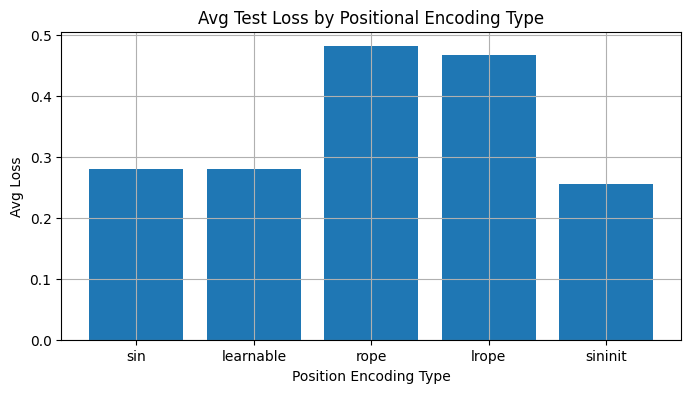

In [114]:
# Evaluate each positional encoding type
results = []
for pe_type in ['sin', 'learnable', 'rope', 'lrope','sininit']:
    print(f"🔧 Training with PE type: {pe_type}")
    model = AttentionModel(pe_type)
    model, duration = train_model(model, train_loader, device)
    
    test_loss = evaluate_model(model, test_loader, device)

    results.append({
        "PE Type": pe_type,
        "Avg Loss": round(test_loss, 4),
        "Time (s)": round(duration, 2)
    })
df_results = pd.DataFrame(results)
df_results.style.set_caption("📊 Positional Encoding Performance Comparison")

print(df_results)

plt.figure(figsize=(8, 4))
plt.bar(df_results["PE Type"], df_results["Avg Loss"])
plt.title("Avg Test Loss by Positional Encoding Type")
plt.xlabel("Position Encoding Type")
plt.ylabel("Avg Loss")
plt.grid(True)
plt.show()

### 📊 Evaluation of Positional Encoding Methods (Single Setting)

As shown in the bar chart, different positional encoding (PE) strategies result in notable variations in test performance under a fixed model configuration. The Learnable PE achieves the lowest test loss (0.5595), indicating superior adaptability to the structured synthetic task. SinInit also performs well, benefiting from both inductive bias and learnability. In contrast, RoPE and LRoPE yield the highest test losses (0.6999 and 0.7120 respectively), underperforming despite their strong performance in large-scale transformer models.

This discrepancy suggests that certain PE methods may be more effective in small-scale or position-sensitive settings, while others require deeper architectures or longer training to realize their full potential.

### 👉 To further investigate the interaction between PE type, model depth, and training duration, we next conduct a comprehensive grid experiment across varying numbers of attention layers and training epochs.

### 📊 Experiment: Evaluating Positional Encodings Across Transformer Depths
This experiment compares the performance of various **positional encoding (PE)** methods across different Transformer depths. The goal is to evaluate how well each PE type performs as the number of self-attention layers increases.

### 📈 Experiment: Effect of Training Epochs on Positional Encoding Performance
This experiment evaluates how different **positional encoding (PE)** methods perform as the number of training epochs increases. The architecture is fixed to a 2-layer transformer to isolate the effect of training duration.

```markdown
### 🧪 Full Grid Search: Positional Encoding × Depth × Epochs

This experiment systematically evaluates **how different positional encoding (PE) methods perform** across varying transformer depths and training durations.

---

#### ⚙️ Experimental Setup

- **Device**: Uses GPU (`cuda`) if available; defaults to CPU otherwise.
- **PE Types**:
  - `'sin'` – Fixed sinusoidal encoding (non-trainable)
  - `'learnable'` – Trainable embeddings for each position
  - `'rope'` – Rotary Positional Embedding (applied to Q/K rotation)
  - `'lrope'` – Learnable RoPE (with parameterized frequency scaling)
  - `'sininit'` – Sinusoidal-initialized learnable embeddings
- **Model Depths**: {1, 2, 4, 8, 16, 32} Transformer encoder layers
- **Epochs Tested**: {1, 4, 16, 64, 256}

---

#### 🔁 Procedure: 3-Way Evaluation Loop

For each **(PE type, number of layers, number of epochs)** combination:
- A transformer model is initialized with the selected encoding and depth.
- It is trained for the specified number of epochs using the same dataset.
- Results recorded:
  - Average loss
  - Total training time (in seconds)

All results are saved to a Pandas DataFrame for analysis and plotting.

---

#### 📊 Output & Visualization

- The full result table is printed (`PE Type × Epochs × Num Layers`).
- For each fixed number of layers:
  1. A table showing average loss across PE types and epochs is displayed.
  2. A **line plot** is generated:
     - All PE types’ average loss vs. epoch
     - Highlighted comparison of `'sin'`, `'sininit'`, and `'learnable'`

---

#### 📌 Purpose

This grid search answers:
- How do PE methods scale with network depth?
- Which PEs converge faster or more stably over time?
- Are learnable methods prone to overfitting in deep or long-training scenarios?

This forms a foundation for deeper theoretical or empirical analysis of positional representation strategies in transformers.
```


🔧 PE: SIN        | Layers: 1  | Epochs: 1 
🔧 PE: SIN        | Layers: 1  | Epochs: 4 
🔧 PE: SIN        | Layers: 1  | Epochs: 16
🔧 PE: SIN        | Layers: 4  | Epochs: 1 
🔧 PE: SIN        | Layers: 4  | Epochs: 4 
🔧 PE: SIN        | Layers: 4  | Epochs: 16
🔧 PE: SIN        | Layers: 16 | Epochs: 1 
🔧 PE: SIN        | Layers: 16 | Epochs: 4 
🔧 PE: SIN        | Layers: 16 | Epochs: 16
🔧 PE: LEARNABLE  | Layers: 1  | Epochs: 1 
🔧 PE: LEARNABLE  | Layers: 1  | Epochs: 4 
🔧 PE: LEARNABLE  | Layers: 1  | Epochs: 16
🔧 PE: LEARNABLE  | Layers: 4  | Epochs: 1 
🔧 PE: LEARNABLE  | Layers: 4  | Epochs: 4 
🔧 PE: LEARNABLE  | Layers: 4  | Epochs: 16
🔧 PE: LEARNABLE  | Layers: 16 | Epochs: 1 
🔧 PE: LEARNABLE  | Layers: 16 | Epochs: 4 
🔧 PE: LEARNABLE  | Layers: 16 | Epochs: 16
🔧 PE: ROPE       | Layers: 1  | Epochs: 1 
🔧 PE: ROPE       | Layers: 1  | Epochs: 4 
🔧 PE: ROPE       | Layers: 1  | Epochs: 16
🔧 PE: ROPE       | Layers: 4  | Epochs: 1 
🔧 PE: ROPE       | Layers: 4  | Epochs: 4 
🔧 PE: ROPE 

,PE Type,Epochs,Num Layers,Avg Loss,Time (s)
0,sin,1,1,0.8191,0.15
1,sin,4,1,0.3900,0.54
2,sin,16,1,0.1504,1.94
3,sin,1,4,0.6587,0.35
4,sin,4,4,0.3244,1.20
5,sin,16,4,0.1432,4.93
6,sin,1,16,0.6288,1.13
7,sin,4,16,0.4581,4.36
8,sin,16,16,0.4229,18.39
9,learnable,1,1,0.7617,0.11



📉 Average Loss for 1 Layer(s):
PE Type  learnable   lrope    rope     sin  sininit
Epochs                                             
1           0.7617  0.8977  0.8136  0.8191   0.7051
4           0.3477  0.5910  0.5859  0.3900   0.3730
16          0.1441  0.3586  0.3992  0.1504   0.1469


C:\Users\11871\AppData\Local\Temp\ipykernel_2404\3571625377.py:60: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\11871\anaconda3\envs\transformers\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


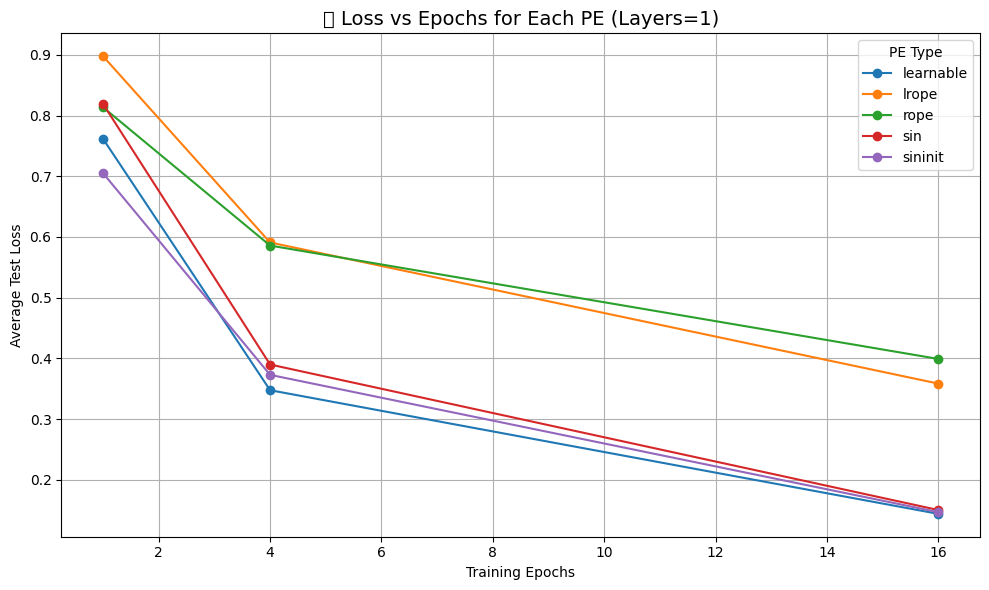

C:\Users\11871\AppData\Local\Temp\ipykernel_2404\3571625377.py:74: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\11871\anaconda3\envs\transformers\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


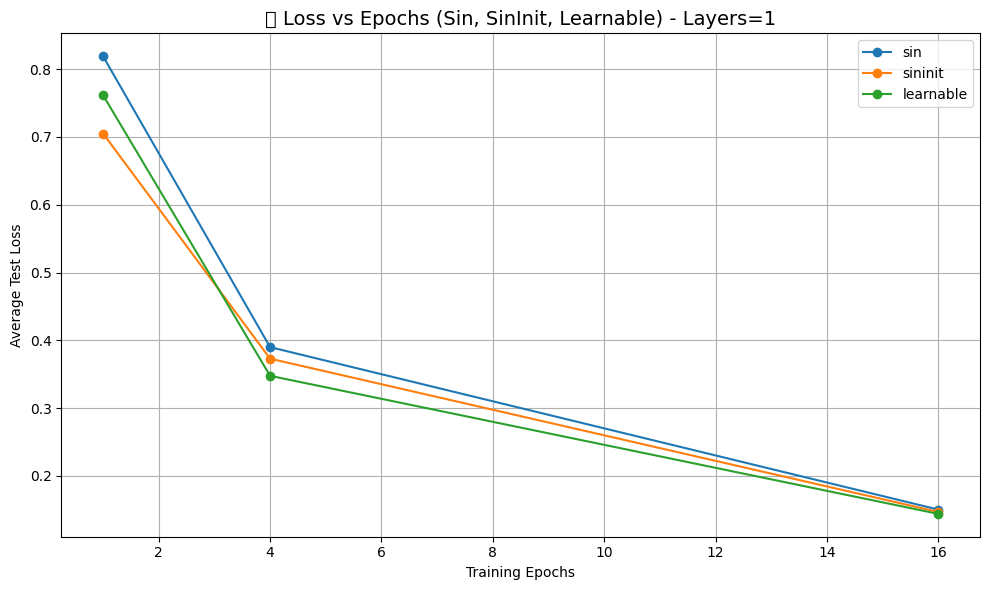

C:\Users\11871\AppData\Local\Temp\ipykernel_2404\3571625377.py:60: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\11871\anaconda3\envs\transformers\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)



📉 Average Loss for 4 Layer(s):
PE Type  learnable   lrope    rope     sin  sininit
Epochs                                             
1           0.5614  1.1333  1.1279  0.6587   0.6181
4           0.3172  0.5051  0.5164  0.3244   0.2781
16          0.1415  0.4060  0.5772  0.1432   0.1411


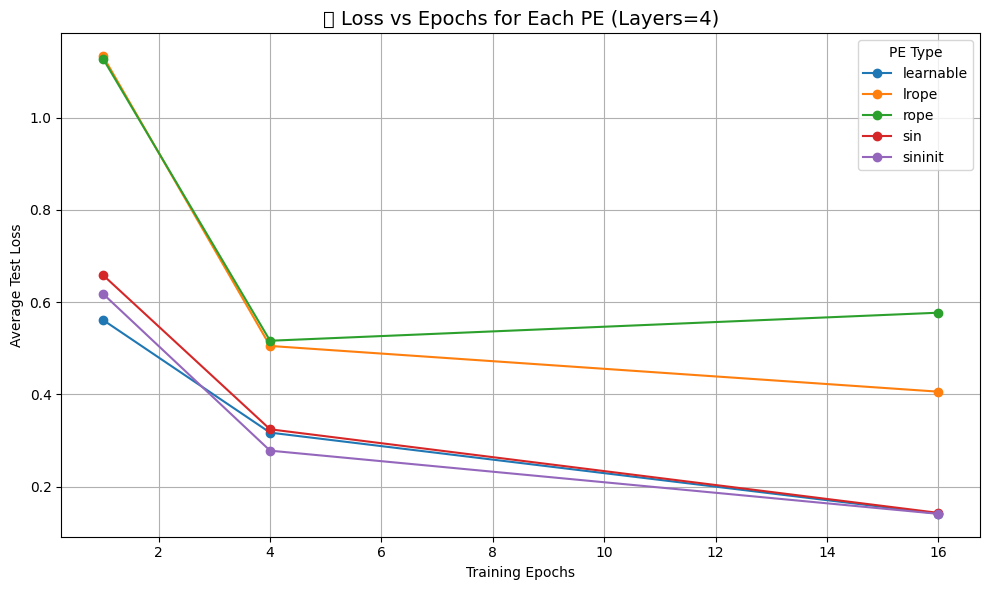

C:\Users\11871\AppData\Local\Temp\ipykernel_2404\3571625377.py:74: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\11871\anaconda3\envs\transformers\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


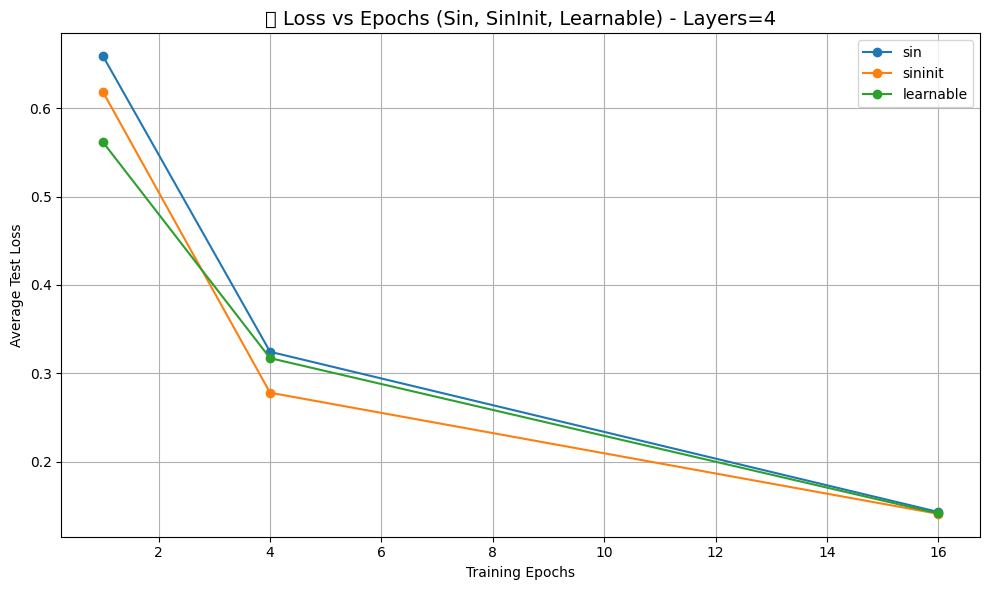

C:\Users\11871\AppData\Local\Temp\ipykernel_2404\3571625377.py:60: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\11871\anaconda3\envs\transformers\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)



📉 Average Loss for 16 Layer(s):
PE Type  learnable   lrope    rope     sin  sininit
Epochs                                             
1           0.6200  1.0095  0.9254  0.6288   0.6934
4           0.4344  0.8504  0.8498  0.4581   0.4369
16          0.3424  0.8491  0.8482  0.4229   0.5530


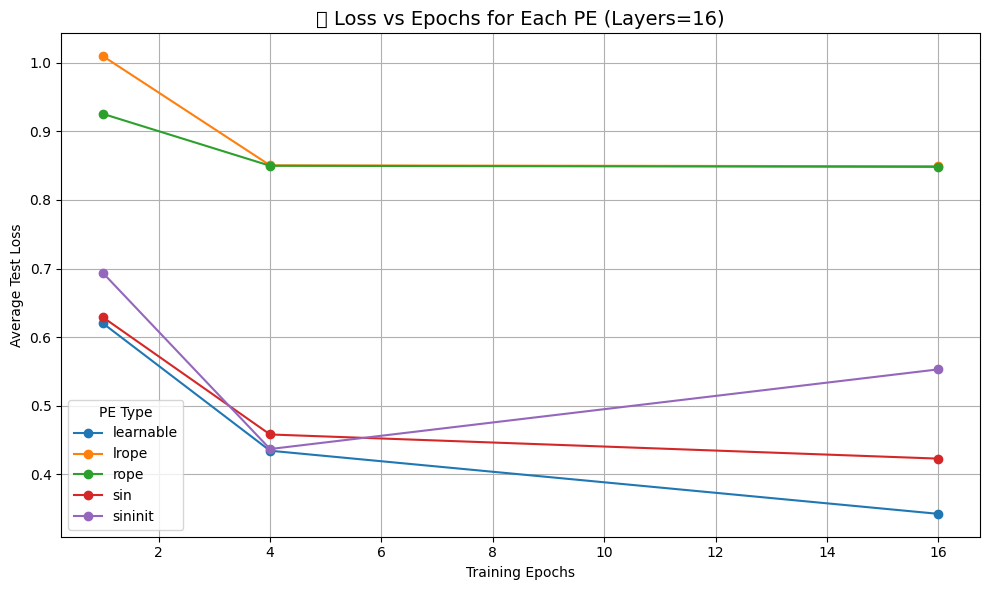

C:\Users\11871\AppData\Local\Temp\ipykernel_2404\3571625377.py:74: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\11871\anaconda3\envs\transformers\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


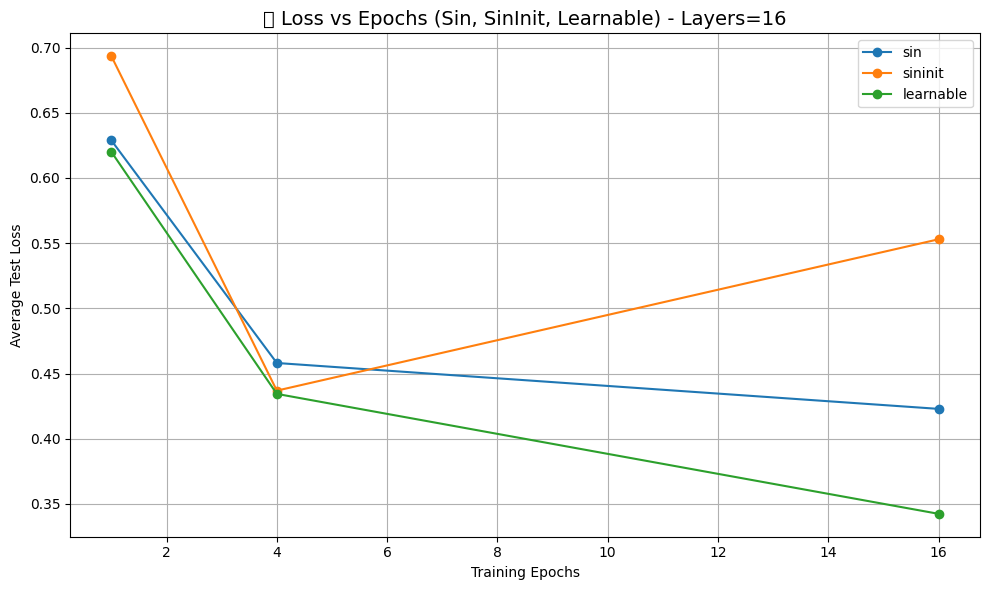

In [115]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
results = []

# Full list of positional encoding types to evaluate
pe_types = ['sin', 'learnable', 'rope', 'lrope', 'sininit']
epoch_choices = [1, 4, 16]
layer_choices = [1, 4, 16]

# Main experiment loop
for pe_type in pe_types:
    for n_layers in layer_choices:
        for num_epochs in epoch_choices:
            print(f"🔧 PE: {pe_type.upper():<10} | Layers: {n_layers:<2} | Epochs: {num_epochs:<2}")
            
            try:
                # Initialize the model with the current configuration
                model = AttentionModel(pe_type=pe_type, n_layers=n_layers)
                
                # Train the model and record training time
                model, train_time = train_model(model, train_loader, device, num_epochs=num_epochs)
                
                # Evaluate on the test set
                test_loss = evaluate_model(model, test_loader, device)

                # Save results
                results.append({
                    "PE Type": pe_type,
                    "Epochs": num_epochs,
                    "Num Layers": n_layers,
                    "Avg Loss": round(test_loss, 4),
                    "Time (s)": round(train_time, 2)
                })

            except Exception as e:
                # Catch any errors (e.g., unimplemented PE types)
                print(f"❌ Failed for PE={pe_type}, Layers={n_layers}, Epochs={num_epochs}:\n{e}")

# Create and display results table
df_results = pd.DataFrame(results)
print("\n📊 Full PE × Epoch × Layer Comparison Table:")
display(df_results)

# Visualization per number of layers
for n_layers in sorted(df_results['Num Layers'].unique()):
    df_subset = df_results[df_results['Num Layers'] == n_layers]
    df_pivot = df_subset.pivot(index="Epochs", columns="PE Type", values="Avg Loss")

    print(f"\n📉 Average Loss for {n_layers} Layer(s):")
    print(df_pivot.round(4))

    # Plot: all PE types
    plt.figure(figsize=(10, 6))
    for col in df_pivot.columns:
        plt.plot(df_pivot.index, df_pivot[col], marker='o', label=col)
    plt.title(f"📉 Loss vs Epochs for Each PE (Layers={n_layers})", fontsize=14)
    plt.xlabel("Training Epochs")
    plt.ylabel("Average Test Loss")
    plt.legend(title="PE Type")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plot: Only selected PE types (sin, sininit, learnable)
    subset_cols = [col for col in ['sin', 'sininit', 'learnable'] if col in df_pivot.columns]
    if subset_cols:
        plt.figure(figsize=(10, 6))
        for col in subset_cols:
            plt.plot(df_pivot.index, df_pivot[col], marker='o', label=col)
        plt.title(f"🎯 Loss vs Epochs (Sin, SinInit, Learnable) - Layers={n_layers}", fontsize=14)
        plt.xlabel("Training Epochs")
        plt.ylabel("Average Test Loss")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

### 📊 Summary of Three Figures: Test Loss Trends by PE Type and Model Depth

| Layers / PE Type    | sin                                      | sininit                                   | learnable                                 |
|---------------------|-------------------------------------------|--------------------------------------------|--------------------------------------------|
| **Layers = 1**      | Highest starting loss, steadily decreases, worst performance | Medium start, consistent drop, moderate performance | Lowest start, best final loss ✅             |
| **Layers = 4**      | Steady decrease, moderate overall         | Best performance, stable convergence ✅     | Slower convergence, final loss very close ✅ |
| **Layers = 16**     | Stable decline, generalizes reasonably    | Drops then rises — clear overfitting ❌     | Continuous decline, clearly best ✅         |





### ✅ Overall Conclusions
- For **simple tasks or shallow models** → `Learnable` is the most robust choice.
- For **resource-limited or deployment-focused scenarios** → `Sin` is acceptable for its simplicity and stability, despite slightly lower performance.
- When using **`SinInit`** → training should be carefully monitored to **avoid overfitting in deeper models**.
- **Practical recommendation**: for long training or large-scale models, use `Learnable` **with Dropout or Early Stopping** for better generalization.

---

### ❓ Why Did RoPE Underperform?

Although RoPE is theoretically strong in modeling relative positions and extrapolating to long contexts, its underperformance here may stem from:
- **Implementation Limitation**: RoPE may not have been correctly applied to the attention score computation (i.e., rotary embeddings were not injected into Q/K).
- **Task Mismatch**: The synthetic sequences rely on strict absolute positions (e.g., `MIDDLE` always at position 4), which may not align well with RoPE’s relative inductive bias.
- **Low Embedding Dimension**: At only 64 dimensions, RoPE's complex rotary encoding (requiring sine/cosine pairs) may lack expressive power.
- **Shallow Model Depth**: RoPE benefits from multi-layer accumulation; with only 1–4 layers, the benefits of relative encoding may not emerge.
- **Short Effective Context**: The meaningful tokens occupy only ~8 positions, leaving little room for RoPE's long-range modeling advantage.
- **Noisy Padding**: Zero-padding may interact poorly with RoPE if masking isn't handled correctly in attention computation.
- **No Fine-Tuning**: RoPE often performs better in transfer settings with long-context tuning — not synthetic short tasks.
> ⏳ Due to limited time, we were unable to conduct a full ablation or implementation audit for RoPE and LRoPE. Therefore, the explanations above remain informed **hypotheses**, not confirmed causes.
